In [10]:
import numpy   as np
import scipy   as sp
import matplotlib.pyplot as plt
import ufl
from dolfinx import fem,io,mesh,plot

from ufl import grad,inner,dx
from mpi4py   import MPI
from petsc4py import PETSc

import dolfinx as dfx

from petsc4py.PETSc import ScalarType

In [11]:
domain=mesh.create_unit_interval(MPI.COMM_WORLD,21)

V=fem.FunctionSpace(domain,("CG",1))
print(V)

FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1), FiniteElement('Lagrange', interval, 2))


In [12]:
#domain.topology.create_connectivity(0, 1)

facets=mesh.locate_entities_boundary(domain,dim=0,marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 1.0)))

boundary_dofs = fem.locate_dofs_topological(V=V, entity_dim=0, entities=facets)
bc=fem.dirichletbc(value=ScalarType(0),dofs=boundary_dofs,V=V)

print(boundary_dofs)
print(bc)


[ 0 41]


In [13]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(domain)

#f = sin(k * pi * x), k=1,10
k=1
f=ufl.sin(k*ufl.pi*x[0])

u_ex_f= lambda x:np.sin(k*np.pi*x)/(k**2*np.pi**2)

a=ufl.dot(grad(u),grad(v))*dx
L=f*v*dx




In [14]:
problem = fem.petsc.LinearProblem(a,L,bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh=problem.solve()
print(type(uh))

<class 'dolfinx.fem.function.Function'>


In [15]:
x=V.tabulate_dof_coordinates()[:,0]
u_ex_f = lambda x: np.sin(k * np.pi * x) / (k**2 * np.pi**2)


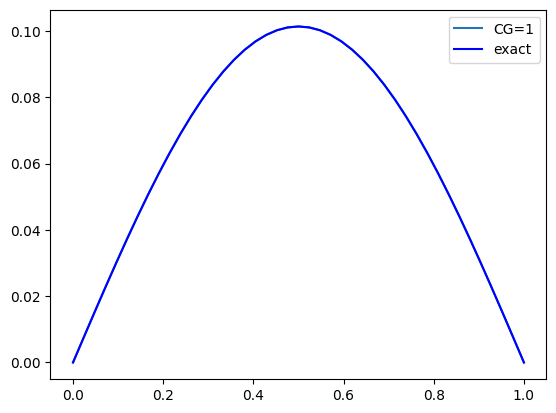

In [16]:
plt.figure()
sort=np.argsort(x)
plt.plot(x[sort],uh.x.array[sort],label=F"CG=1")
plt.plot(x[sort],u_ex_f(x[sort]),label=F"exact",color="b")

#error=dfx.fem.Function(V)
#error.x.array[:]=uh.x.array-u_ex_f

#error_local = dfx.fem.form(inner(error, error) * dx)
#error_local = dfx.fem.assemble_scalar(error_local)
#error_global = mesh.comm.allreduce(error_local, op = MPI.SUM)
#error_global = np.sqrt(error_global)

#print(f"Error L2 (assemble) CG{i + 1}: ", error_global)
#print(f"Error L2 CG{i + 1}: \t\t ", calc_error_L2(sol[i], u_ex[i], x[i]))
#print(f"Error l2 CG{i + 1}: \t\t ", calc_error_l2(sol[i], u_ex[i]))
#print("")
    
plt.legend()
plt.show()



In [17]:
from dolfinx.fem import form
from utils import L2_norm

E=L2_norm(uh,u_ex_f(x))
print(E)